# Import necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import openai
from sklearn.metrics import classification_report
from tqdm import tqdm
from langchain_ollama.llms import OllamaLLM
from langchain_google_vertexai import ChatVertexAI
from langchain.chains import LLMChain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.messages.ai import AIMessage
from langchain_google_vertexai import ChatVertexAI
import plotly.express as px
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import neattext.functions as nfx
import os
from typing import List, Dict, Any, Optional
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from sklearn.metrics import f1_score

/opt/miniconda3/envs/emo-rec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load EmoryNLP dataset

In [2]:
df_train = pd.read_csv("datasets/emorynlp/emorynlp_train_final.csv")
df_test = pd.read_csv("datasets/emorynlp/emorynlp_test_final.csv")

**Converting emotion labels to lowercase ensures consistency, especially when comparing labels or using them in classification tasks where case sensitivity might lead to mismatches.**

In [3]:
# Convert all emotion labels to lowercase
df_train["Emotion"] = df_train["Emotion"].str.lower()
df_test["Emotion"] = df_test["Emotion"].str.lower()

In [4]:
example_text = "I thought things would get better with time, but it just keeps hurting more."
emotion_labels = df_train["Emotion"].unique().tolist()
emotion_labels

['joyful', 'neutral', 'powerful', 'mad', 'sad', 'scared', 'peaceful']

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Utterance     984 non-null    object
 1   Speaker       984 non-null    object
 2   Emotion       984 non-null    object
 3   Scene_ID      984 non-null    int64 
 4   Utterance_ID  984 non-null    int64 
 5   Season        984 non-null    int64 
 6   Episode       984 non-null    int64 
 7   Start_Time    984 non-null    object
 8   End_Time      984 non-null    object
dtypes: int64(4), object(5)
memory usage: 69.3+ KB


In [6]:
df_test.head()

,Utterance,Speaker,Emotion,Scene_ID,Utterance_ID,Season,Episode,Start_Time,End_Time
0,I'm supposed to attach a brackety thing to the...,['Ross Geller'],mad,4,1,1,1,00:09:34.865,00:09:51.423
1,I'm thinking we've got a bookcase here.,['Joey Tribbiani'],neutral,4,3,1,1,00:09:39.453,00:09:42.247
2,It's a beautiful thing.,['Chandler Bing'],joyful,4,4,1,1,00:09:43.416,00:09:48.169
3,What's this?,['Joey Tribbiani'],neutral,4,5,1,1,00:09:48.337,00:09:51.423
4,Which goes where?,['Joey Tribbiani'],neutral,4,7,1,1,00:09:53.009,00:09:57.262


### 📊 Emotion Distribution in the EmoryNLP Training Set

Before training any models, I explore the class distribution of emotions in the EmoryNLP training dataset. 
    
To visualize this, I create a **pie chart** showing the relative frequency of each emotion label, with percentage values displayed in the legend. This provides an intuitive overview of the emotional makeup of the dataset and helps inform decisions regarding model evaluation and potential rebalancing strategies.


In [7]:
df_train["Emotion"].value_counts()

Emotion
neutral     2485
joyful      1677
scared       941
mad          785
peaceful     638
powerful     551
sad          474
Name: count, dtype: int64

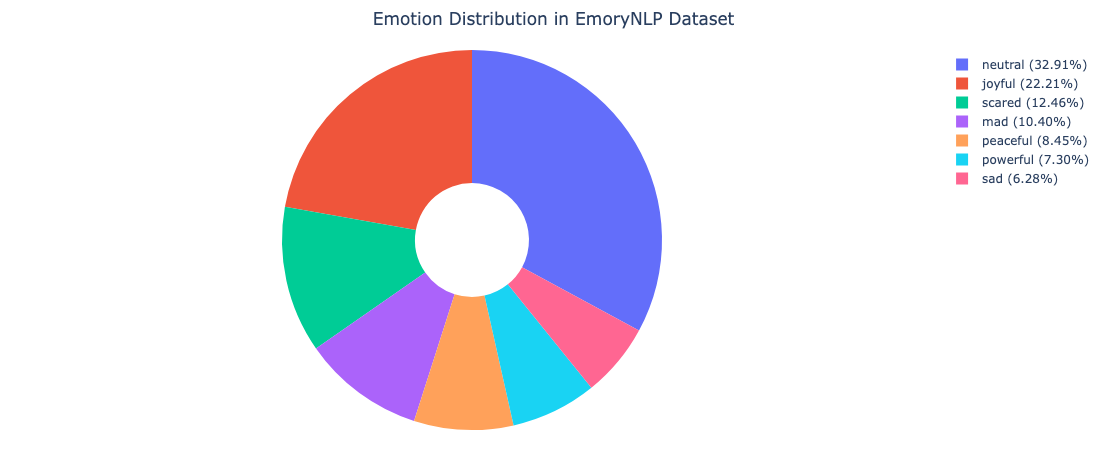

In [8]:
# Get counts and percentages
df_value_counts = df_train["Emotion"].value_counts()
labels = list(df_value_counts.keys())
sizes = df_value_counts.tolist()

# Calculate formatted labels: "emotion (xx.xx%)"
total = sum(sizes)
legend_labels = [f"{label} ({(count/total)*100:.2f}%)" for label, count in zip(labels, sizes)]

# Create pie chart
fig = go.Figure(
    data=[go.Pie(
        labels=legend_labels,     # legend-style labels
        values=sizes,
        textinfo='none',          # remove text from inside the pie
        hole=0.3
    )]
)

# Update layout: legend in top-right
fig.update_layout(
    title="Emotion Distribution in EmoryNLP Dataset",
    width=600,
    height=450,
    margin=dict(l=20, r=20, t=50, b=20),
    title_x=0.5,
    legend=dict(
        orientation="v",
        x=1.02,
        y=1,
        xanchor="left",
        yanchor="top",
        font=dict(size=12)
    )
)

fig.show()


**To ensure faster evaluation and reduce API costs during large language model inference, I limit the EmoryNLP test set to the first 500 examples.**

In [9]:
test_size = 500
print(f"test size is reduced from {len(df_test)} to {test_size}")
df_test = df_test[:test_size]

test size is reduced from 984 to 500


**To uniquely identify conversations, I assign a Dialogue_ID to each group of utterances that belong to the same scene, season, and episode. This helps in reconstructing dialogue history for context-aware emotion classification.**

In [10]:
# Create a new Dialogue_ID column by grouping on (Scene_ID, Season, Episode)
df_test["Dialogue_ID"] = df_test.groupby(["Scene_ID", "Season", "Episode"]).ngroup() + 1

**To remove the square brackets and quotes (i.e., convert ['Monica Geller'] → Monica Geller) from the Speaker column, you can use the following code:**

In [11]:
# Remove square brackets and quotes from speaker strings
df_test["Speaker"] = df_test["Speaker"].str.strip("[]").str.replace("'", "").str.strip()

In [12]:
df_test.head()

,Utterance,Speaker,Emotion,Scene_ID,Utterance_ID,Season,Episode,Start_Time,End_Time,Dialogue_ID
0,I'm supposed to attach a brackety thing to the...,Ross Geller,mad,4,1,1,1,00:09:34.865,00:09:51.423,10
1,I'm thinking we've got a bookcase here.,Joey Tribbiani,neutral,4,3,1,1,00:09:39.453,00:09:42.247,10
2,It's a beautiful thing.,Chandler Bing,joyful,4,4,1,1,00:09:43.416,00:09:48.169,10
3,What's this?,Joey Tribbiani,neutral,4,5,1,1,00:09:48.337,00:09:51.423,10
4,Which goes where?,Joey Tribbiani,neutral,4,7,1,1,00:09:53.009,00:09:57.262,10


# Evaluation

In [13]:
model_scores = {} # save weighted f1 scores for each model

## 🧪 Supervised Emotion Classification with Traditional ML Models

In this section, I apply three traditional supervised learning models—**Logistic Regression**, **Support Vector Classifier (SVC)**, and **Random Forest Classifier**—to the EmoryNLP dataset for text-based emotion classification.

First, I preprocess the training utterances by removing user handles and stopwords. Then, I use the `CountVectorizer` to convert the cleaned text into numerical feature vectors. These vectors serve as input to the classifiers.

Each model is wrapped in a `scikit-learn` pipeline for streamlined preprocessing and training. After training, I evaluate the models on the test split of the EmoryNLP dataset using standard classification metrics (precision, recall, and F1-score).


Preprocess the utterances and assign the cleaned utterances and corresponding emotions to x_train and y_train, respectively, for training.

In [14]:
x_train, y_train = df_train["Utterance"].apply(nfx.remove_userhandles).apply(nfx.remove_stopwords), df_train['Emotion']

### Logistic Regression

In [15]:
pipe_lr = Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression(max_iter=100))])
pipe_lr.fit(x_train, y_train)
print("Logistic regrestion model is ready to use!")

Logistic regrestion model is ready to use!


In [16]:
lr_predictions = pipe_lr.predict(df_test["Utterance"].values)

In [17]:
print("Evaluation results on the EmoryNLP dataset using Logistic Regression:\n")
print(classification_report(df_test["Emotion"], lr_predictions, zero_division=0))
model_scores["Logistic Regression"] = f1_score(df_test["Emotion"], lr_predictions, average='weighted', zero_division=0)

Evaluation results on the EmoryNLP dataset using Logistic Regression:

              precision    recall  f1-score   support

      joyful       0.41      0.38      0.39       102
         mad       0.24      0.20      0.22        49
     neutral       0.43      0.61      0.51       165
    peaceful       0.19      0.09      0.12        43
    powerful       0.00      0.00      0.00        42
         sad       0.25      0.08      0.12        37
      scared       0.21      0.31      0.25        62

    accuracy                           0.35       500
   macro avg       0.25      0.24      0.23       500
weighted avg       0.31      0.35      0.32       500



### SVC

In [18]:
pipe_svc = Pipeline(steps=[('cv', CountVectorizer()), ('svc', SVC(kernel='rbf', C=10))])
pipe_svc.fit(x_train, y_train)
print("SVC model is ready to use!")

SVC model is ready to use!


In [19]:
svc_predictions = pipe_svc.predict(df_test["Utterance"].values)

In [20]:
print("Evaluation results on the EmoryNLP dataset using SVC:\n")
print(classification_report(df_test["Emotion"], svc_predictions, zero_division=0))
model_scores["SVC"] = f1_score(df_test["Emotion"], svc_predictions, average='weighted', zero_division=0)

Evaluation results on the EmoryNLP dataset using SVC:

              precision    recall  f1-score   support

      joyful       0.28      0.56      0.38       102
         mad       0.17      0.14      0.15        49
     neutral       0.50      0.52      0.51       165
    peaceful       0.38      0.14      0.20        43
    powerful       0.00      0.00      0.00        42
         sad       0.31      0.11      0.16        37
      scared       0.23      0.18      0.20        62

    accuracy                           0.34       500
   macro avg       0.27      0.23      0.23       500
weighted avg       0.32      0.34      0.31       500



### Random Forest Classifier

In [21]:
pipe_rf = Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier(n_estimators=10))])
pipe_rf.fit(x_train, y_train)
print("Random Forest Classifier model is ready to use!")

Random Forest Classifier model is ready to use!


In [22]:
rf_predictions = pipe_rf.predict(df_test["Utterance"].values)

In [23]:
print("Evaluation results on the EmoryNLP dataset using Random Forest Classifier:\n")
print(classification_report(df_test["Emotion"], rf_predictions, zero_division=0))
model_scores["Random Forest Classifier"] = f1_score(df_test["Emotion"], rf_predictions, average='weighted', zero_division=0)

Evaluation results on the EmoryNLP dataset using Random Forest Classifier:

              precision    recall  f1-score   support

      joyful       0.31      0.28      0.30       102
         mad       0.14      0.18      0.16        49
     neutral       0.37      0.48      0.42       165
    peaceful       0.22      0.14      0.17        43
    powerful       0.00      0.00      0.00        42
         sad       0.18      0.11      0.14        37
      scared       0.19      0.18      0.18        62

    accuracy                           0.28       500
   macro avg       0.20      0.20      0.19       500
weighted avg       0.25      0.28      0.26       500



In [24]:
weighted_f1 = f1_score(df_test["Emotion"], rf_predictions, average='weighted', zero_division=0)
print(f"Weighted F1-score: {weighted_f1:.4f}")

Weighted F1-score: 0.2612


## 🔍 Zero-Shot Emotion Classification with `facebook/bart-large-mnli`
To evaluate an alternative approach without supervised training, I use the [`facebook/bart-large-mnli`](https://huggingface.co/facebook/bart-large-mnli) model from Hugging Face for **zero-shot classification**. This model allows emotion classification by comparing each utterance directly against a set of candidate labels, without requiring task-specific fine-tuning.

For each utterance, the model ranks the candidate emotions based on how well they match the text. The top-ranked label is selected as the predicted emotion.

In [25]:
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Device set to use mps:0


In [26]:
result = zero_shot_classifier(example_text, candidate_labels=emotion_labels)
result["labels"][0]

'sad'

In [27]:
zero_shot_predictions = []
for text in tqdm(df_test["Utterance"]):
    output = zero_shot_classifier(text, candidate_labels=emotion_labels)
    zero_shot_predictions.append(output["labels"][0])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:21<00:00,  6.10it/s]


In [28]:
print("Evaluation results on the EmoryNLP dataset using facebook/bart-large-mnli (zero-shot classification):\n")
print(classification_report(df_test["Emotion"], zero_shot_predictions, zero_division=0))
model_scores["facebook/bart-large-mnli"] = f1_score(df_test["Emotion"], zero_shot_predictions, average='weighted', zero_division=0)

Evaluation results on the EmoryNLP dataset using facebook/bart-large-mnli (zero-shot classification):

              precision    recall  f1-score   support

      joyful       0.57      0.12      0.20       102
         mad       0.15      0.27      0.20        49
     neutral       0.36      0.07      0.12       165
    peaceful       0.05      0.02      0.03        43
    powerful       0.09      0.52      0.15        42
         sad       0.21      0.27      0.24        37
      scared       0.24      0.19      0.21        62

    accuracy                           0.16       500
   macro avg       0.24      0.21      0.16       500
weighted avg       0.31      0.16      0.16       500



## 🤖 Emotion Classification with `emotion-english-distilroberta-base`

In this step, I evaluate a transformer-based model fine-tuned specifically for emotion classification: [`j-hartmann/emotion-english-distilroberta-base`](https://huggingface.co/j-hartmann/emotion-english-distilroberta-base). This model is built on top of DistilRoBERTa and has been trained on multiple English emotion datasets.

Using the Hugging Face `text-classification` pipeline, I apply the model to each utterance in the dataset and extract the top predicted emotion label. I then compare the predicted labels to the ground-truth annotations using standard classification metrics.

In [29]:
distilroberta_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

Device set to use mps:0


In [30]:
result = distilroberta_classifier(example_text)
result

[{'label': 'sadness', 'score': 0.8036125302314758}]

In [31]:
emotion_mapping = {
    "joy": "joyful",
    "neutral": "neutral",
    "surprise": "powerful",
    "fear": "scared",
    "sadness": "sad",
    "disgust": "mad",
    "anger": "mad"
}
predictions_distilroberta = []
for text in tqdm(df_test["Utterance"]):
    output = distilroberta_classifier(text, top_k=1)
    mapped_emotion = emotion_mapping[output[0]["label"]]
    predictions_distilroberta.append(mapped_emotion)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 74.07it/s]


In [32]:
print("Evaluation results on the EmoryNLP dataset using j-hartmann/emotion-english-distilroberta-base (text classification):\n")
print(classification_report(df_test["Emotion"], predictions_distilroberta, zero_division=0))
model_scores["j-hartmann/emotion-english-distilroberta-base"] = f1_score(df_test["Emotion"], predictions_distilroberta, average='weighted', zero_division=0)

Evaluation results on the EmoryNLP dataset using j-hartmann/emotion-english-distilroberta-base (text classification):

              precision    recall  f1-score   support

      joyful       0.47      0.19      0.27       102
         mad       0.17      0.35      0.23        49
     neutral       0.40      0.52      0.45       165
    peaceful       0.00      0.00      0.00        43
    powerful       0.05      0.14      0.08        42
         sad       0.24      0.16      0.19        37
      scared       0.40      0.06      0.11        62

    accuracy                           0.28       500
   macro avg       0.25      0.20      0.19       500
weighted avg       0.32      0.28      0.26       500



## 🤖 Emotion Classification using Large Language Models and Prompt Engineering

In this section, I evaluate the emotion classification capabilities of several large language models (LLMs) using **prompt-based inference**, without task-specific fine-tuning. This approach leverages the few-shot and instruction-following capabilities of modern LLMs for **in-context learning**.

#### 💡 Models Used

I tested the following LLMs across various prompting strategies:

* **`llama3.1:8b`** via **Ollama**
* **`gpt-4.1-nano`** via **OpenAI API**
* **`gemini-2.5-flash-lite`** via **Vertex AI**

These models were evaluated using a consistent framework to ensure comparability.

#### 🧠 Prompting Strategies

To understand how different types of prompts affect performance, I evaluated each model with the following five prompt types:

1. **Zero-shot prompt**: The model receives only the target utterance and is expected to infer the emotion label from a predefined list, with no prior examples.
2. **One-shot prompt**: A single labeled example is provided before the target utterance.
3. **Few-shot prompt**: Multiple labeled examples (covering all emotion classes) are provided to guide the model's prediction.
4. **Contextual prompt**: The model receives the target utterance along with the preceding utterances from the same conversation to account for dialogue context.
5. **Retrieval-Augmented Contextual prompt**: In addition to the conversation history, the model is shown one **relevant example** from the training dataset, retrieved via semantic similarity using a **vector store (FAISS)**. This combines **retrieval-augmented generation (RAG)** principles with conversational context.

#### 🧰 Framework Components

To support this evaluation, I implemented several utility classes:

* **`EmoryNLPDataManager`**: Organizes utterances by dialogue and retrieves conversation history given a dialogue and utterance ID.
* **`DemonstrationRetriever`**: Builds a semantic vector store using sentence embeddings (`all-MiniLM-L6-v2`) and retrieves the most similar utterance from the training set for use in retrieval-augmented prompts.
* **`PromptGenerator`**: Generates different prompt templates in a modular way, including support for history and demonstrations.
* **`evaluate_emotion_classification`**: A unified evaluation function that constructs the prompt, queries the model, extracts predicted labels, and reports performance metrics.

#### 📊 Evaluation

Each model was tested on the same EmoryNLP test split with all five prompt types. The outputs were evaluated using **precision, recall, and F1-score**, and the predicted labels were extracted using a rule-based parser that identifies the first valid emotion label in the model output.

In [33]:
class EmoryNLPDataManager:
    def __init__(self, dataframe: pd.DataFrame):
        self.df = dataframe.copy()
        self.dialogues: Dict[int, List[Dict[str, Any]]] = {}
        for dialogue_id, group in self.df.groupby('Dialogue_ID'):
            self.dialogues[dialogue_id] = group.sort_values(by='Utterance_ID').to_dict('records')

    def get_conversation_history(self, dialogue_id: int, utterance_id: int, window_size: int = 9) -> List[Dict[str, Any]]:
        if dialogue_id not in self.dialogues: return []
        conversation = self.dialogues[dialogue_id]
        target_idx = next((i for i, u in enumerate(conversation) if u['Utterance_ID'] == utterance_id), -1)
        if target_idx == -1: return []
        start_idx = max(0, target_idx - window_size)
        return conversation[start_idx:target_idx]

In [34]:
class DemonstrationRetriever:
    """
    Handles creating an in-memory vector store and retrieving demonstrations.
    This version does NOT save the vector store to disk.
    """
    def __init__(self, train_df: pd.DataFrame, embedding_model_name: str = 'all-MiniLM-L6-v2'):
        """
        Initializes the retriever by creating an in-memory FAISS vector store from train_df.
        """
        print("Initializing DemonstrationRetriever and creating in-memory vector store...")
        self.embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)
        documents = train_df['Utterance'].tolist()
        metadatas = train_df[['Emotion']].to_dict('records')
        self.vector_store = FAISS.from_texts(documents, self.embeddings, metadatas=metadatas)
        print("In-memory vector store created successfully.")

    def retrieve_demonstration(self, query_utterance: str) -> str:
        results = self.vector_store.similarity_search(query_utterance, k=1)
        if not results: return "No demonstration found."
        retrieved_doc = results[0]
        return f"Utterance: \"{retrieved_doc.page_content}\"\nEmotion: {retrieved_doc.metadata.get('Emotion', 'N/A')}"


In [35]:
class PromptGenerator:
    """
    A toolkit for generating various ChatPromptTemplates for emotion recognition.
    """
    EMORYNLP_EMOTION_LABELS = emotion_labels

    def _format_history(self, history: List[Dict[str, Any]]) -> str:
        if not history: return "This is the first utterance in the conversation."
        return "\n".join([f"{u['Speaker']}: \"{u['Utterance']}\"" for u in history])

    def _format_target_utterance(self, target_utterance: Dict[str, Any]) -> str:
        return f"{target_utterance['Speaker']}: \"{target_utterance['Utterance']}\""

    def get_zero_shot_template(self) -> ChatPromptTemplate:
        """Returns a basic zero-shot classification prompt."""
        emotion_options = ", ".join(self.EMORYNLP_EMOTION_LABELS)
        template = ChatPromptTemplate.from_messages([
            ("system", f"You are a classification assistant. Only output one of the following emotion labels: {emotion_options}. No explanation."),
            ("user", "Utterance: {utterance}\nEmotion:")
        ])
        template.name = "zero_shot_prompt"
        return template

    def get_one_shot_template(self) -> ChatPromptTemplate:
        """Returns a one-shot classification prompt with a single example."""
        emotion_options = ", ".join(self.EMORYNLP_EMOTION_LABELS)
        template = ChatPromptTemplate.from_messages([
            ("system", f"You are an assistant that labels user utterances with one of the following emotions: {emotion_options}. Please give only the label!"),
            ("user", "Utterance: That’s fine. I’m okay with it. → Emotion: neutral\nUtterance: {utterance} → Emotion:")
        ])
        template.name = "one_shot_prompt"
        return template

    def get_few_shot_template(self) -> ChatPromptTemplate:
        """Returns a few-shot classification prompt with multiple examples."""
        emotion_options = ", ".join(self.EMORYNLP_EMOTION_LABELS)
        template = ChatPromptTemplate.from_messages([
            ("system", f"You are an assistant that labels user utterances with one of the following emotions: {emotion_options}. Please give only the label!"),
            ("user", """Examples:

Utterance: I just got the job I really wanted!
Emotion: joyful

Utterance: Everything's fine, I guess.
Emotion: neutral

Utterance: I can do this. I believe in myself!
Emotion: powerful

Utterance: This is so unfair!
Emotion: mad

Utterance: I feel so alone lately.
Emotion: sad

Utterance: What if something bad happens?
Emotion: scared

Utterance: I feel calm and at peace with everything.
Emotion: peaceful

Now classify:
Utterance: "{utterance}"
Emotion:""")
        ])
        template.name = "few_shot_prompt"
        return template

    def get_contextual_template(self) -> ChatPromptTemplate:
        """Returns an InstructERC-style prompt with history but no demonstration."""
        emotion_options = ", ".join(self.EMORYNLP_EMOTION_LABELS)
        system_template = ("You are an expert in conversational analysis. Your task is to identify the emotion of the "
                           "TARGET UTTERANCE based on the CONVERSATION HISTORY. "
                           f"You must only output one of the following emotion labels: <{emotion_options}>. Do not provide any explanation.")
        user_template = ("### CONVERSATION HISTORY ###\n{history}\n\n"
                         "### TARGET UTTERANCE ###\n{target_utterance_with_speaker}\n\n"
                         "Emotion:")
        template = ChatPromptTemplate.from_messages([("system", system_template), ("user", user_template)])
        template.name = "contextual_prompt"
        return template

    def get_retrieval_augmented_contextual_template(self) -> ChatPromptTemplate:
        """Returns the full InstructERC-style prompt with history and a demonstration."""
        emotion_options = ", ".join(self.EMORYNLP_EMOTION_LABELS)
        system_template = ("You are an expert in conversational analysis. Your task is to identify the emotion of the "
                           "TARGET UTTERANCE based on the provided DEMONSTRATION example and the CONVERSATION HISTORY. "
                           f"You must only output one of the following emotion labels: <{emotion_options}>. Do not provide any explanation.")
        user_template = ("### DEMONSTRATION ###\n{demonstration}\n\n"
                         "### CONVERSATION HISTORY ###\n{history}\n\n"
                         "### TARGET UTTERANCE ###\n{target_utterance_with_speaker}\n\n"
                         "Emotion:")
        template = ChatPromptTemplate.from_messages([("system", system_template), ("user", user_template)])
        template.name = "retrieval_augmented_contextual_prompt"
        return template

In [36]:
def extract_emotion_from_output(output_text: str, valid_labels: List[str]) -> Optional[str]:
    output_text = output_text.lower()
    first_found = None
    first_index = len(output_text) + 1
    for label in valid_labels:
        try:
            idx = output_text.find(label)
            if idx != -1 and idx < first_index:
                first_index = idx
                first_found = label
        except AttributeError:
            return "neutral"
    return first_found if first_found else "neutral"

def print_classification_report(labels: List[str], predictions: List[str], llm_name: str, prompt_name: str):
    print(f"\n📌 Evaluating with model: {llm_name}")
    print(f"📄 Prompt Template Type: {prompt_name}\n")
    print(classification_report(labels, predictions, zero_division=0))
    
def evaluate_emotion_classification(df: pd.DataFrame, llm, prompt: ChatPromptTemplate, data_manager: EmoryNLPDataManager, retriever: Optional[DemonstrationRetriever] = None, limit: Optional[int] = None, verbose: bool = False, print_report: bool = False):
    if verbose:
        print(f"\n📌 Evaluating with model: {llm.model}")
        print(f"📄 Prompt Template Type: {prompt.name}")
    results = []
    df_subset = df.head(limit) if limit else df
    for idx, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc=f"Evaluating {prompt.name} using {llm.name}"):
        input_dict = {}
        if prompt.name in ["zero_shot_prompt", "one_shot_prompt", "few_shot_prompt"]:
            input_dict = {"utterance": row['Utterance']}
        elif prompt.name in ["contextual_prompt", "retrieval_augmented_contextual_prompt"]:
            history_list = data_manager.get_conversation_history(row['Dialogue_ID'], row['Utterance_ID'])
            input_dict["history"] = prompt_generator._format_history(history_list)
            input_dict["target_utterance_with_speaker"] = prompt_generator._format_target_utterance(row)
            if prompt.name == "retrieval_augmented_contextual_prompt":
                input_dict["demonstration"] = retriever.retrieve_demonstration(row['Utterance'])
        prompt_input = prompt.invoke(input_dict)
        raw_output = llm.invoke(prompt_input)
        if isinstance(raw_output, AIMessage):
            raw_output = raw_output.content
        predicted_emotion = extract_emotion_from_output(raw_output, PromptGenerator.EMORYNLP_EMOTION_LABELS)
        results.append(predicted_emotion)
    
    model_scores[f"{llm.name} with {prompt.name}"] = f1_score(df_subset["Emotion"], results, average='weighted', zero_division=0)
    
    if print_report:
        print_classification_report(df_subset["Emotion"].tolist(), results, llm.name, prompt.name)
    return results

In [37]:
retriever = DemonstrationRetriever(train_df=df_train)
data_manager = EmoryNLPDataManager(df_test)
prompt_generator = PromptGenerator()

Initializing DemonstrationRetriever and creating in-memory vector store...
In-memory vector store created successfully.


### LLM: "llama3.1:8b"

In [38]:
llama3_8b = OllamaLLM(model="llama3.1:8b")
llama3_8b.name = "llama3.1:8b"

In [39]:
_ = evaluate_emotion_classification(
    df=df_test, llm=llama3_8b, prompt=prompt_generator.get_zero_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating zero_shot_prompt using llama3.1:8b: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:02<00:00,  4.08it/s]


📌 Evaluating with model: llama3.1:8b
📄 Prompt Template Type: zero_shot_prompt

              precision    recall  f1-score   support

      joyful       0.48      0.37      0.42       102
         mad       0.29      0.39      0.33        49
     neutral       0.46      0.76      0.57       165
    peaceful       0.09      0.02      0.04        43
    powerful       0.14      0.05      0.07        42
         sad       0.30      0.35      0.33        37
      scared       0.36      0.06      0.11        62

    accuracy                           0.41       500
   macro avg       0.30      0.29      0.27       500
weighted avg       0.36      0.41      0.35       500



In [40]:
_ = evaluate_emotion_classification(
    df=df_test, llm=llama3_8b, prompt=prompt_generator.get_one_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating one_shot_prompt using llama3.1:8b: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [02:13<00:00,  3.75it/s]


📌 Evaluating with model: llama3.1:8b
📄 Prompt Template Type: one_shot_prompt

              precision    recall  f1-score   support

      joyful       0.47      0.56      0.51       102
         mad       0.27      0.43      0.33        49
     neutral       0.53      0.53      0.53       165
    peaceful       0.11      0.05      0.06        43
    powerful       0.21      0.17      0.19        42
         sad       0.24      0.30      0.27        37
      scared       0.33      0.21      0.25        62

    accuracy                           0.40       500
   macro avg       0.31      0.32      0.31       500
weighted avg       0.38      0.40      0.38       500



In [41]:
_ = evaluate_emotion_classification(
    df=df_test, llm=llama3_8b, prompt=prompt_generator.get_few_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating few_shot_prompt using llama3.1:8b: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:57<00:00,  4.25it/s]


📌 Evaluating with model: llama3.1:8b
📄 Prompt Template Type: few_shot_prompt

              precision    recall  f1-score   support

      joyful       0.55      0.28      0.37       102
         mad       0.23      0.57      0.33        49
     neutral       0.48      0.70      0.57       165
    peaceful       0.25      0.09      0.14        43
    powerful       0.32      0.14      0.20        42
         sad       0.36      0.22      0.27        37
      scared       0.38      0.18      0.24        62

    accuracy                           0.40       500
   macro avg       0.37      0.31      0.30       500
weighted avg       0.42      0.40      0.38       500



In [42]:
_ = evaluate_emotion_classification(
    df=df_test, llm=llama3_8b, prompt=prompt_generator.get_contextual_template(),
    data_manager=data_manager, print_report=True)

Evaluating contextual_prompt using llama3.1:8b: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:20<00:00,  1.92it/s]


📌 Evaluating with model: llama3.1:8b
📄 Prompt Template Type: contextual_prompt

              precision    recall  f1-score   support

      joyful       0.45      0.38      0.41       102
         mad       0.21      0.51      0.30        49
     neutral       0.48      0.41      0.44       165
    peaceful       0.13      0.12      0.12        43
    powerful       0.14      0.10      0.11        42
         sad       0.24      0.43      0.31        37
      scared       0.33      0.11      0.17        62

    accuracy                           0.33       500
   macro avg       0.28      0.29      0.27       500
weighted avg       0.35      0.33      0.32       500



In [43]:
_ = evaluate_emotion_classification(
    df=df_test, llm=llama3_8b, prompt=prompt_generator.get_retrieval_augmented_contextual_template(),
    data_manager=data_manager, retriever=retriever, print_report=True)

Evaluating retrieval_augmented_contextual_prompt using llama3.1:8b: 100%|██████████████████████████████████████████████████████████████████████████| 500/500 [06:35<00:00,  1.27it/s]


📌 Evaluating with model: llama3.1:8b
📄 Prompt Template Type: retrieval_augmented_contextual_prompt

              precision    recall  f1-score   support

      joyful       0.46      0.46      0.46       102
         mad       0.18      0.35      0.23        49
     neutral       0.51      0.33      0.40       165
    peaceful       0.15      0.14      0.14        43
    powerful       0.10      0.12      0.11        42
         sad       0.20      0.38      0.26        37
      scared       0.26      0.13      0.17        62

    accuracy                           0.30       500
   macro avg       0.26      0.27      0.25       500
weighted avg       0.35      0.30      0.31       500



### LLM: "gpt-4.1-nano"

In [44]:
gpt_4_1_nano = ChatOpenAI(model="gpt-4.1-nano", temperature=0)
gpt_4_1_nano.name = "gpt_4_1_nano"

In [45]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gpt_4_1_nano, prompt=prompt_generator.get_zero_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating zero_shot_prompt using gpt_4_1_nano: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:56<00:00,  2.11it/s]


📌 Evaluating with model: gpt_4_1_nano
📄 Prompt Template Type: zero_shot_prompt

              precision    recall  f1-score   support

      joyful       0.49      0.48      0.49       102
         mad       0.24      0.33      0.28        49
     neutral       0.51      0.69      0.59       165
    peaceful       0.12      0.05      0.07        43
    powerful       0.26      0.21      0.24        42
         sad       0.37      0.30      0.33        37
      scared       0.41      0.21      0.28        62

    accuracy                           0.43       500
   macro avg       0.34      0.32      0.32       500
weighted avg       0.40      0.43      0.41       500



In [46]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gpt_4_1_nano, prompt=prompt_generator.get_one_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating one_shot_prompt using gpt_4_1_nano: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.00it/s]


📌 Evaluating with model: gpt_4_1_nano
📄 Prompt Template Type: one_shot_prompt

              precision    recall  f1-score   support

      joyful       0.44      0.60      0.50       102
         mad       0.21      0.29      0.24        49
     neutral       0.54      0.60      0.57       165
    peaceful       0.00      0.00      0.00        43
    powerful       0.24      0.19      0.21        42
         sad       0.55      0.30      0.39        37
      scared       0.38      0.32      0.35        62

    accuracy                           0.43       500
   macro avg       0.34      0.33      0.32       500
weighted avg       0.40      0.43      0.40       500



In [47]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gpt_4_1_nano, prompt=prompt_generator.get_few_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating few_shot_prompt using gpt_4_1_nano: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:49<00:00,  2.18it/s]


📌 Evaluating with model: gpt_4_1_nano
📄 Prompt Template Type: few_shot_prompt

              precision    recall  f1-score   support

      joyful       0.52      0.46      0.49       102
         mad       0.23      0.35      0.28        49
     neutral       0.46      0.68      0.55       165
    peaceful       0.17      0.02      0.04        43
    powerful       0.13      0.07      0.09        42
         sad       0.62      0.22      0.32        37
      scared       0.29      0.24      0.26        62

    accuracy                           0.41       500
   macro avg       0.35      0.29      0.29       500
weighted avg       0.39      0.41      0.38       500



In [48]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gpt_4_1_nano, prompt=prompt_generator.get_contextual_template(),
    data_manager=data_manager, print_report=True)

Evaluating contextual_prompt using gpt_4_1_nano: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.01it/s]


📌 Evaluating with model: gpt_4_1_nano
📄 Prompt Template Type: contextual_prompt

              precision    recall  f1-score   support

      joyful       0.47      0.62      0.54       102
         mad       0.33      0.33      0.33        49
     neutral       0.48      0.73      0.58       165
    peaceful       0.00      0.00      0.00        43
    powerful       0.17      0.02      0.04        42
         sad       0.38      0.27      0.32        37
      scared       0.25      0.06      0.10        62

    accuracy                           0.43       500
   macro avg       0.30      0.29      0.27       500
weighted avg       0.36      0.43      0.37       500



In [49]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gpt_4_1_nano, prompt=prompt_generator.get_retrieval_augmented_contextual_template(),
    data_manager=data_manager, retriever=retriever, print_report=True)

Evaluating retrieval_augmented_contextual_prompt using gpt_4_1_nano: 100%|█████████████████████████████████████████████████████████████████████████| 500/500 [04:05<00:00,  2.04it/s]


📌 Evaluating with model: gpt_4_1_nano
📄 Prompt Template Type: retrieval_augmented_contextual_prompt

              precision    recall  f1-score   support

      joyful       0.51      0.46      0.48       102
         mad       0.35      0.29      0.31        49
     neutral       0.44      0.64      0.52       165
    peaceful       0.13      0.09      0.11        43
    powerful       0.11      0.05      0.07        42
         sad       0.31      0.24      0.27        37
      scared       0.36      0.26      0.30        62

    accuracy                           0.40       500
   macro avg       0.31      0.29      0.29       500
weighted avg       0.37      0.40      0.37       500



### LLM: "gemini-2.5-flash-lite"

In [50]:
gemini_2_5_flash_lite = ChatVertexAI(model="gemini-2.5-flash-lite", temperature=0)
gemini_2_5_flash_lite.name = "gemini-2.5-flash-lite"

In [51]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gemini_2_5_flash_lite, prompt=prompt_generator.get_zero_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating zero_shot_prompt using gemini-2.5-flash-lite: 100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:10<00:00,  2.62it/s]


📌 Evaluating with model: gemini-2.5-flash-lite
📄 Prompt Template Type: zero_shot_prompt

              precision    recall  f1-score   support

      joyful       0.55      0.39      0.46       102
         mad       0.33      0.43      0.38        49
     neutral       0.45      0.81      0.58       165
    peaceful       0.17      0.02      0.04        43
    powerful       0.17      0.02      0.04        42
         sad       0.34      0.41      0.37        37
      scared       0.38      0.05      0.09        62

    accuracy                           0.43       500
   macro avg       0.34      0.30      0.28       500
weighted avg       0.39      0.43      0.37       500



In [52]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gemini_2_5_flash_lite, prompt=prompt_generator.get_one_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating one_shot_prompt using gemini-2.5-flash-lite: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:06<00:00,  2.68it/s]


📌 Evaluating with model: gemini-2.5-flash-lite
📄 Prompt Template Type: one_shot_prompt

              precision    recall  f1-score   support

      joyful       0.59      0.32      0.42       102
         mad       0.27      0.57      0.37        49
     neutral       0.45      0.73      0.56       165
    peaceful       0.00      0.00      0.00        43
    powerful       0.38      0.07      0.12        42
         sad       0.28      0.30      0.29        37
      scared       0.35      0.13      0.19        62

    accuracy                           0.41       500
   macro avg       0.33      0.30      0.28       500
weighted avg       0.39      0.41      0.36       500



In [53]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gemini_2_5_flash_lite, prompt=prompt_generator.get_few_shot_template(),
    data_manager=data_manager, print_report=True)

Evaluating few_shot_prompt using gemini-2.5-flash-lite: 100%|██████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:12<00:00,  2.59it/s]


📌 Evaluating with model: gemini-2.5-flash-lite
📄 Prompt Template Type: few_shot_prompt

              precision    recall  f1-score   support

      joyful       0.58      0.22      0.31       102
         mad       0.31      0.41      0.35        49
     neutral       0.41      0.88      0.56       165
    peaceful       0.00      0.00      0.00        43
    powerful       0.33      0.02      0.04        42
         sad       0.36      0.22      0.27        37
      scared       0.38      0.10      0.15        62

    accuracy                           0.40       500
   macro avg       0.34      0.26      0.24       500
weighted avg       0.38      0.40      0.33       500



In [54]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gemini_2_5_flash_lite, prompt=prompt_generator.get_contextual_template(),
    data_manager=data_manager, print_report=True)

Evaluating contextual_prompt using gemini-2.5-flash-lite: 100%|████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:12<00:00,  2.59it/s]


📌 Evaluating with model: gemini-2.5-flash-lite
📄 Prompt Template Type: contextual_prompt

              precision    recall  f1-score   support

      joyful       0.79      0.19      0.30       102
         mad       0.28      0.45      0.34        49
     neutral       0.42      0.89      0.57       165
    peaceful       0.50      0.02      0.04        43
    powerful       0.50      0.02      0.05        42
         sad       0.38      0.38      0.38        37
      scared       0.75      0.10      0.17        62

    accuracy                           0.42       500
   macro avg       0.52      0.29      0.27       500
weighted avg       0.53      0.42      0.34       500



In [55]:
_ = evaluate_emotion_classification(
    df=df_test, llm=gemini_2_5_flash_lite, prompt=prompt_generator.get_retrieval_augmented_contextual_template(),
    data_manager=data_manager, retriever=retriever, print_report=True)

Evaluating retrieval_augmented_contextual_prompt using gemini-2.5-flash-lite: 100%|████████████████████████████████████████████████████████████████| 500/500 [04:09<00:00,  2.01it/s]


📌 Evaluating with model: gemini-2.5-flash-lite
📄 Prompt Template Type: retrieval_augmented_contextual_prompt

              precision    recall  f1-score   support

      joyful       0.56      0.32      0.41       102
         mad       0.34      0.37      0.35        49
     neutral       0.43      0.71      0.54       165
    peaceful       0.27      0.07      0.11        43
    powerful       0.20      0.10      0.13        42
         sad       0.27      0.46      0.34        37
      scared       0.48      0.16      0.24        62

    accuracy                           0.40       500
   macro avg       0.36      0.31      0.30       500
weighted avg       0.41      0.40      0.37       500



### 📊 Visualizing Model Performance with Weighted F1 Scores

To compare the effectiveness of different models on the EmoryNLP dataset, I visualize their **weighted F1 scores** using a horizontal bar chart. The weighted F1 score accounts for class imbalance by weighting each class’s F1 score by its support (i.e., number of true instances).

In [56]:
fig = go.Figure(go.Bar(
    x=list(model_scores.values()),
    y=list(model_scores.keys()),
    orientation='h',
    text=[f"{v:.2f}" for v in model_scores.values()],
    textposition='auto'
))

fig.update_layout(
    title="Model Comparison by Weighted F1 Score on the EmoryNLP dataset",
    xaxis_title="Weighted F1 Score",
    yaxis_title="Model",
    xaxis_range=[0, 1],
    width=1200,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50),
)

fig.show()
